### Result
- Private LB : 1.37246
- Rank : 2205 (Top 49%)

| model | train RMSLE | valid RMSLE | Public LB | Private LB | Rank |
| -- | :-: | :-: | :-: | :-: | :-: |
| LightGBM |1.01657 | 1.34053 | 1.42723 | 1.38412 |
| XGBoost |  0.82379 | 1.34365 | 1.43763 | 1.41386 |
| CatBoost | 1.33138 | 1.38511 | 1.42232 | **1.37246** |2205 (49%)
| Simple Average | 1.03638 | 1.33945| **1.41484** | 1.37273 | 

## Experiment 01
### Feature Engineering
- remove single-valued columns
- select top 1000 features with RandomForest model's feature importance
- add PCA (n=10) feature
- add statistical features

### Validation Scheme
- random 8:2 split

### Model
- LightGBM
- XGBoost
- CatBoost

### Ensemble
- Simple Average

In [1]:
import numpy as np
import pandas as pd
from tools import *
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

import matplotlib
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

In [2]:
comp_name = 'santander-value-prediction-challenge'
train_path = '../data/train.csv'
test_path = '../data/test.csv'

In [3]:
# load data
trn = pd.read_csv(train_path)
tst = pd.read_csv(test_path)

In [4]:
trn_id = trn.ID
y = trn.target
tst_id = tst.ID

In [5]:
trn.drop(['ID', 'target'], axis=1, inplace=True)
tst.drop(['ID'], axis=1, inplace=True)

## Feature Engineering

In [6]:
# remove sinlge-valued columns
single_valued_cols = trn.columns[trn.nunique() == 1].tolist()

trn.drop(single_valued_cols, axis=1, inplace=True)
tst.drop(single_valued_cols, axis=1, inplace=True)

In [7]:
trn.shape, tst.shape

((4459, 4735), (49342, 4735))

In [8]:
# fit RandomForest model for feature selection (top 1000)
x_trn, x_val, y_trn, y_val = train_test_split(trn, y, test_size=0.2, random_state=2018)
model = RandomForestRegressor(n_estimators=30, oob_score=True, 
                              max_depth=50, min_samples_leaf=2, max_features='sqrt',
                              random_state=2018, n_jobs=-1)
model.fit(x_trn, y_trn)
evaluate(model, x_trn, y_trn, x_val, y_val, rmsle)

# trn loss : 1.59926114702
# val loss : 1.87004084113
# trn R2 : 0.625764458839
# val R2 : 0.353736481115
# OOB_score : 0.211184092716


In [9]:
# show important columns
feature_imp = pd.DataFrame({'col': x_trn.columns.tolist(),
                            'imp': model.feature_importances_})
feature_imp.sort_values(by='imp', ascending=False, inplace=True)
feature_imp.head(10)

,col,imp
4135,f190486d6,0.019924
3576,58232a6fb,0.017585
8,20aa07010,0.014248
3727,d6bb78916,0.008766
4025,15ace8c9f,0.008340
2378,58e2e02e6,0.008323
1008,1c71183bb,0.008034
627,fb49e4212,0.006798
3470,eeb9cd3aa,0.006424
4190,f74e8f13d,0.006223


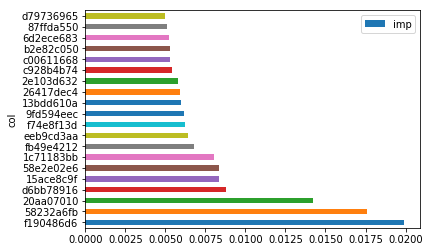

In [10]:
feature_imp[feature_imp.imp > 0].head(20).plot.barh('col', 'imp')

In [11]:
# choose top 1000 features
num_features = 1000
keep_cols = feature_imp[feature_imp.imp > 0.0001][:num_features].col.values

trn = trn[keep_cols]
tst = tst[keep_cols]

In [12]:
trn.shape, tst.shape

((4459, 1000), (49342, 1000))

In [13]:
# re-train RandomForest to check how feature importance has changed
x_trn, x_val, y_trn, y_val = train_test_split(trn, y, test_size=0.2, random_state=2018)
model = RandomForestRegressor(n_estimators=30, oob_score=True, 
                              max_depth=50, min_samples_leaf=2, max_features='sqrt',
                              random_state=2018, n_jobs=-1)
model.fit(x_trn, y_trn)
evaluate(model, x_trn, y_trn, x_val, y_val, rmsle)

# trn loss : 1.51868626181
# val loss : 1.83925138126
# trn R2 : 0.675168397713
# val R2 : 0.365649265696
# OOB_score : 0.226808645078


In [14]:
feature_imp = pd.DataFrame({'col': x_trn.columns.tolist(),
                            'imp': model.feature_importances_})
feature_imp.sort_values(by='imp', ascending=False, inplace=True)
feature_imp.head(10)

,col,imp
0,f190486d6,0.020762
7,fb49e4212,0.013331
52,6eef030c1,0.013195
5,58e2e02e6,0.010353
29,1702b5bf0,0.009541
3,d6bb78916,0.008883
4,15ace8c9f,0.008500
41,b43a7cfd5,0.008383
215,122c135ed,0.008038
1,58232a6fb,0.008036


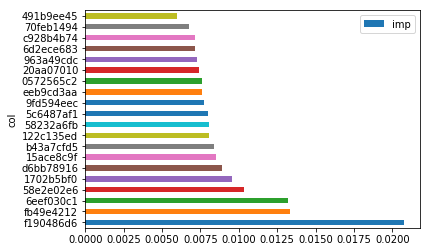

In [15]:
# Top feature feature remains same, orders have changed bit for others
feature_imp[feature_imp.imp > 0].head(20).plot.barh('col', 'imp')

In [16]:
# add statistical features
trn['cnt_zero'] = (trn == 0).sum(axis=1)
tst['cnt_zero'] = (tst == 0).sum(axis=1)

trn['sum'] = trn.sum(axis=1)
tst['sum'] = tst.sum(axis=1)

tmp_trn = trn[trn!=0]
tmp_tst = tst[tst!=0]
trn['var'] = tmp_trn.var(axis=1)
tst['var'] = tmp_tst.var(axis=1)

trn['median'] = tmp_trn.median(axis=1)
tst['median'] = tmp_tst.median(axis=1)

trn['mean'] = tmp_trn.mean(axis=1)
tst['mean'] = tmp_tst.mean(axis=1)

trn['std'] = tmp_trn.std(axis=1)
tst['std'] = tmp_tst.std(axis=1)

trn['max'] = tmp_trn.max(axis=1)
tst['max'] = tmp_tst.max(axis=1)

trn['min'] = tmp_trn.min(axis=1)
tst['min'] = tmp_tst.min(axis=1)

In [17]:
# add PCA features
n_components = 10
pca = PCA(n_components=n_components, random_state=2018)
pca.fit(trn)

cols = ['pca_{}'.format(i) for i in range(n_components)]
pca_trn = pd.DataFrame(pca.transform(trn), columns=cols)
pca_tst = pd.DataFrame(pca.transform(tst), columns=cols)

trn = pd.concat([trn, pca_trn], axis=1)
tst = pd.concat([tst, pca_tst], axis=1)

## Model

In [18]:
# lightGBM
x_trn, x_val, y_trn, y_val = train_test_split(trn, y, test_size=0.2, random_state=2018)
lgb_train = lgb.Dataset(x_trn, np.log1p(y_trn))
lgb_eval = lgb.Dataset(x_val, np.log1p(y_val), reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# train
gbm = lgb.train(params, lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=5)

[1]	training's rmse: 1.70451	valid_1's rmse: 1.75156
Training until validation scores don't improve for 5 rounds.
[2]	training's rmse: 1.6716	valid_1's rmse: 1.72168
[3]	training's rmse: 1.63884	valid_1's rmse: 1.69157
[4]	training's rmse: 1.60849	valid_1's rmse: 1.66389
[5]	training's rmse: 1.5804	valid_1's rmse: 1.63716
[6]	training's rmse: 1.55375	valid_1's rmse: 1.61285
[7]	training's rmse: 1.52877	valid_1's rmse: 1.59145
[8]	training's rmse: 1.50572	valid_1's rmse: 1.57269
[9]	training's rmse: 1.48446	valid_1's rmse: 1.5555
[10]	training's rmse: 1.46408	valid_1's rmse: 1.53818
[11]	training's rmse: 1.44516	valid_1's rmse: 1.52237
[12]	training's rmse: 1.42775	valid_1's rmse: 1.50687
[13]	training's rmse: 1.41152	valid_1's rmse: 1.49422
[14]	training's rmse: 1.39648	valid_1's rmse: 1.48238
[15]	training's rmse: 1.38178	valid_1's rmse: 1.47102
[16]	training's rmse: 1.36803	valid_1's rmse: 1.46126
[17]	training's rmse: 1.35502	valid_1's rmse: 1.45206
[18]	training's rmse: 1.34298	val

In [19]:
# make prediction
lgb_tst = gbm.predict(tst, num_iteration=gbm.best_iteration)
tst_subm = pd.DataFrame({'ID': tst_id, 'target': np.exp(lgb_tst) - 1 })
fname = 'lgbm.1000feat_statFeats'
tst_subm.to_csv(fname, index=False)
submit_kaggle_result(comp_name, fname, msg='')
check_kaggle_result(comp_name, fname)

In [20]:
# XGBoost
xgb_train = xgb.DMatrix(x_trn, np.log1p(y_trn))
xgb_eval = xgb.DMatrix(x_val, np.log1p(y_val))

params = {
    'boostser': 'gbtree',
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
}

# train
evallist = [(xgb_eval, 'eval'), (xgb_train, 'train')]
bst = xgb.train(params, xgb_train, evals=evallist,
                num_boost_round=100,
                early_stopping_rounds=10)

[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	eval-rmse:13.3052	train-rmse:13.4271
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-rmse:12.6445	train-rmse:12.7642
[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	eval-rmse:12.0193	train-rmse:12.1365
[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[3]	eval-rmse:11.4248	train-rmse:11.54
[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[4]	eval-rmse:10.8596	train-rmse:10.9733
[11:20:26] /workspace/src/tree/updater_pru

[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[49]	eval-rmse:1.71322	train-rmse:1.53771
[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[50]	eval-rmse:1.68136	train-rmse:1.49275
[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[51]	eval-rmse:1.65129	train-rmse:1.45244
[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[52]	eval-rmse:1.62536	train-rmse:1.41377
[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[53]	eval-rmse:1.60136	train-rmse:1.3759
[11:20:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[54]	eval-rmse:1.57603	train-rmse:1.34095

[11:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[98]	eval-rmse:1.34361	train-rmse:0.829306
[11:20:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[99]	eval-rmse:1.34365	train-rmse:0.823799


In [21]:
# make prediction
xgb_tst = xgb.DMatrix(tst)
tst_pred = bst.predict(xgb_tst)
tst_subm = pd.DataFrame({'ID': tst_id, 'target': np.exp(tst_pred) - 1 })
fname = 'xgb.1000feat_statFeats'
tst_subm.to_csv(fname, index=False)
submit_kaggle_result(comp_name, fname, msg='')
check_kaggle_result(comp_name, fname)

In [22]:
# Catboost
cat_trn = cat.Pool(x_trn, np.log1p(y_trn))
cat_val = cat.Pool(x_val, np.log1p(y_val))

# catboost param
# https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_parameters-list-docpage/#python-reference_parameters-list
params = {
    'iterations': 1000,
    'depth': 2,
    'learning_rate': 0.05,
    'loss_function': 'RMSE',
    'random_seed': 2018,
}

# train
model = cat.CatBoostRegressor(**params)
model.fit(cat_trn, eval_set=cat_val, early_stopping_rounds=10)

0:	learn: 13.9020772	test: 13.7786759	best: 13.7786759 (0)	total: 60.1ms	remaining: 1m
1:	learn: 13.2204004	test: 13.0970588	best: 13.0970588 (1)	total: 69.6ms	remaining: 34.7s
2:	learn: 12.5726391	test: 12.4496264	best: 12.4496264 (2)	total: 80.1ms	remaining: 26.6s
3:	learn: 11.9583516	test: 11.8357460	best: 11.8357460 (3)	total: 88.8ms	remaining: 22.1s
4:	learn: 11.3752897	test: 11.2531749	best: 11.2531749 (4)	total: 99.2ms	remaining: 19.7s
5:	learn: 10.8215422	test: 10.6998561	best: 10.6998561 (5)	total: 108ms	remaining: 17.9s
6:	learn: 10.2961085	test: 10.1748779	best: 10.1748779 (6)	total: 117ms	remaining: 16.5s
7:	learn: 9.7980095	test: 9.6777031	best: 9.6777031 (7)	total: 125ms	remaining: 15.6s
8:	learn: 9.3253010	test: 9.2063423	best: 9.2063423 (8)	total: 134ms	remaining: 14.7s
9:	learn: 8.8766791	test: 8.7584487	best: 8.7584487 (9)	total: 142ms	remaining: 14.1s
10:	learn: 8.4513304	test: 8.3354174	best: 8.3354174 (10)	total: 151ms	remaining: 13.6s
11:	learn: 8.0482144	test: 7.

108:	learn: 1.4153189	test: 1.4501832	best: 1.4501832 (108)	total: 1.04s	remaining: 8.54s
109:	learn: 1.4145864	test: 1.4496853	best: 1.4496853 (109)	total: 1.05s	remaining: 8.53s
110:	learn: 1.4141043	test: 1.4492420	best: 1.4492420 (110)	total: 1.06s	remaining: 8.52s
111:	learn: 1.4121737	test: 1.4465620	best: 1.4465620 (111)	total: 1.07s	remaining: 8.5s
112:	learn: 1.4109942	test: 1.4459140	best: 1.4459140 (112)	total: 1.08s	remaining: 8.5s
113:	learn: 1.4095355	test: 1.4448003	best: 1.4448003 (113)	total: 1.09s	remaining: 8.48s
114:	learn: 1.4087256	test: 1.4442854	best: 1.4442854 (114)	total: 1.1s	remaining: 8.46s
115:	learn: 1.4079735	test: 1.4441654	best: 1.4441654 (115)	total: 1.11s	remaining: 8.45s
116:	learn: 1.4066222	test: 1.4429134	best: 1.4429134 (116)	total: 1.12s	remaining: 8.43s
117:	learn: 1.4054653	test: 1.4419661	best: 1.4419661 (117)	total: 1.13s	remaining: 8.42s
118:	learn: 1.4044787	test: 1.4407622	best: 1.4407622 (118)	total: 1.13s	remaining: 8.4s
119:	learn: 1.

217:	learn: 1.3528324	test: 1.3960279	best: 1.3958645 (215)	total: 2.05s	remaining: 7.34s
218:	learn: 1.3525053	test: 1.3960725	best: 1.3958645 (215)	total: 2.06s	remaining: 7.33s
219:	learn: 1.3521964	test: 1.3957727	best: 1.3957727 (219)	total: 2.07s	remaining: 7.33s
220:	learn: 1.3520603	test: 1.3957229	best: 1.3957229 (220)	total: 2.08s	remaining: 7.32s
221:	learn: 1.3516255	test: 1.3954805	best: 1.3954805 (221)	total: 2.09s	remaining: 7.32s
222:	learn: 1.3510398	test: 1.3949635	best: 1.3949635 (222)	total: 2.1s	remaining: 7.31s
223:	learn: 1.3503802	test: 1.3945285	best: 1.3945285 (223)	total: 2.11s	remaining: 7.32s
224:	learn: 1.3500656	test: 1.3943894	best: 1.3943894 (224)	total: 2.12s	remaining: 7.31s
225:	learn: 1.3495383	test: 1.3942717	best: 1.3942717 (225)	total: 2.13s	remaining: 7.3s
226:	learn: 1.3491996	test: 1.3940334	best: 1.3940334 (226)	total: 2.14s	remaining: 7.29s
227:	learn: 1.3489666	test: 1.3940903	best: 1.3940334 (226)	total: 2.15s	remaining: 7.28s
228:	learn: 

In [23]:
# make prediction
cat_tst = cat.Pool(tst)
tst_pred = model.predict(cat_tst)
tst_subm = pd.DataFrame({'ID': tst_id, 'target': np.exp(tst_pred) - 1 })
fname = 'cat.1000feat_statFeats'
tst_subm.to_csv(fname, index=False)
submit_kaggle_result(comp_name, fname, msg='')
check_kaggle_result(comp_name, fname)

## Ensemble

In [24]:
# simple average
cat_sub = pd.read_csv('cat.1000feat_statFeats')
xgb_sub = pd.read_csv('xgb.1000feat_statFeats')
lgb_sub = pd.read_csv('lgbm.1000feat_statFeats')

subm = cat_sub.copy()
subm.target = (cat_sub.target + xgb_sub.target + lgb_sub.target) / 3

fname = 'cat_xgb_lgb_avg.1000feat_statFeats'
subm.to_csv(fname, index=False)
submit_kaggle_result(comp_name, fname, msg='')
check_kaggle_result(comp_name, fname)

In [25]:
# get train-valid loss for ensemble
cat_trn_pred = model.predict(cat_trn)
xgb_trn_pred = bst.predict(xgb_train)
lgb_trn_pred = gbm.predict(x_trn, num_iteration=gbm.best_iteration)

cat_val_pred = model.predict(cat_val)
xgb_val_pred = bst.predict(xgb_eval)
lgb_val_pred = gbm.predict(x_val, num_iteration=gbm.best_iteration)

trn_pred = (cat_trn_pred + xgb_trn_pred + lgb_trn_pred) / 3
val_pred = (cat_val_pred + xgb_val_pred + lgb_val_pred) / 3

rmsle(y_trn, np.expm1(trn_pred)), rmsle(y_val, np.expm1(val_pred))

(1.0363827466432083, 1.3394552165231157)